## <h1><center>Práctica Grupal: Prediciendo resultados de cáncer</center></h1>

<div align= "center">Metodos Probabilisticos</div>
<div align= "center">Máster en Inteligencia Artificial Aplicada (UC3M)</div>
<div align= "center">González-Varas Vallejo
Íñigo (100514179);Lillo Collado, Laura (100508801); Sánchez Sánchez, Alba (100406577)</div>

## **Librerias utilizadas**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR
import statsmodels.api as sm
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


scaler = StandardScaler()

In [3]:

from sklearn.model_selection import learning_curve
# Define una función para crear la curva de aprendizaje
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Número de ejemplos de entrenamiento")
    plt.ylabel("Puntuación")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Precisión en entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Precisión en prueba")

    plt.legend(loc="best")

    return plt

## **1. Carga del conjunto de datos**

El conjunto de datos que manipularemos durante este proyecto está basado en muestras de imagenes digitalizadas obtenidas mediante el aspirado con aguja fina (PAAF) de un amasa mamaria

In [4]:
data = pd.read_csv('data.csv',delimiter=";")
#data.drop(['Unnamed: 32'], axis=1, inplace=True)
data.head()

,ID,diagnosis,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


- ***Estudio y transformaciones iniciales***

En primer lugar, estudiamos la existencia de duplicados en los datos, por ejemplo si un paciente se ha introducio dos veces en la base de datos.

In [5]:
# Comprobación de duplicados
existen_duplicados = data.duplicated().any()
if existen_duplicados:
    print("Existen datos duplicados en el DataFrame.")
else:
    print("No existen datos duplicados en el DataFrame.")

No existen datos duplicados en el DataFrame.


Una vez comprobado que no existen duplicados, se elimina el identificador de cada registro ya que no aporta nada en la predicción.

In [6]:
# Eliminación de los id
data.drop(['ID'], axis=1, inplace=True)

In [7]:
data.head()

,diagnosis,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Ahora, se comprueba si existen valores nulos en la base de datos para determinar su tratamiento.

In [8]:
nulls = data.isnull().sum()
names_nulls = {}
for i in nulls.index:
    if nulls[i]!=0:
        names_nulls[i] = nulls[i]
if len(names_nulls)==0:
    print('No existen valores nulos.')
else:
    print(names_nulls)

No existen valores nulos.


- ***Análisis descriptivo de la base de datos***

Realizamos un análisis descriptivo del conjunto de datos para comprender resumidamete la naturaleza de los mismos.

In [9]:
# Variable objetivo: diagnosis
print('Descripción general:')
print('--------------------')
print(data['diagnosis'].describe())
print('\nFrecuencia de cada clase:')
print('-------------------------')
print(data['diagnosis'].value_counts())
from collections import Counter
class_counts = Counter(data['diagnosis'])
minority_class = min(class_counts.values())
majority_class = max(class_counts.values())
class_balance_ratio = minority_class / majority_class
print('\nRazón de equilibrio de clases:')
print('------------------------------')
print(class_balance_ratio)


Descripción general:
--------------------
count     569
unique      2
top         B
freq      357
Name: diagnosis, dtype: object

Frecuencia de cada clase:
-------------------------
diagnosis
B    357
M    212
Name: count, dtype: int64

Razón de equilibrio de clases:
------------------------------
0.5938375350140056


En total tenemos 569 registros ene l conjunto de datos donde la variable categorica contiene dos categorías: 'B' (Benigno) y 'M' (Maligno).


El recuento de frecuencia nos muestra que hay 357 muestras de 'B'  y 212 muestras de 'M'. Por lo tanto, el registro minoritario es 'M'. Estos valores hay que tenerlos en cuenta en el análisis y entrenamiento con modelos de clasificación pues puede afectar tanto a la precisión como al rendimiento. Este apartado lo discutiremos en la etapa de entrenamiento

In [10]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


***Separación en conjunto entrenamiento y evaluación***

Antes de comenzar con la manipulación de los datos separamos en conjunto de entrenamiento y evaluación. Esto nos permite realizar las transformaciones oportunas de manera independiente.

In [11]:
train_dig,test_dig = train_test_split(data, test_size=0.2, random_state=42)

In [12]:
print(f"Porcentaje de train: {len(train_dig)} muestras")
print(f"Porcentaje de test: {len(test_dig)} muestras")

Porcentaje de train: 455 muestras
Porcentaje de test: 114 muestras


###Preprocesado y manipulación del conjunto de entrenamiento.

En primer lugar realizamos las transformaciones en nuestro conjunto de entrenamiento que corresponde al 80 % de las muestras.

In [13]:
train = train_dig.copy()

In [14]:
X_train_dig = train_dig.drop(['diagnosis'], axis=1, inplace=False)

- **Manejo de datos faltantes**

Identificar y tratamos los valores faltantes. De esta forma aseguramos que el conjunto de entrenamiento sea completo y apto para la etapa de modelado. Si existieran datos faltantes tendriamos que eliminarlos o imputarlos para evitar que afecten negativamente a la calidad de los resultados.

La manera de imputar estos datos sería utilizando la media, la mediana o la moda. Reemplazando cada valor faltante por este resultado. También podríamos utilizar técnicas de regresión o imputación por vecinos más cercanos (K-NN).

In [15]:
valores_faltantes_por_variable = train.isnull().sum()
variables_con_valores_faltantes = valores_faltantes_por_variable[valores_faltantes_por_variable > 0]
print(variables_con_valores_faltantes)


Series([], dtype: int64)


No existen valores faltantes en nuestro conjunto de entrenamiento.

- **Codificación de variables categóricas**

El proceso de transformación de variables categóricas permiten que los algoritmos en la etapa de entrenamiento trabajen de manera más efectiva.

En nuestro caso, la variable categorica es el resultado de si el diagnosis es benigno o maligno. Aplicamos entonces el método **get_dummies** para transformar estos valores de 'B' y 'M' a 0 y 1. Como resultado tenemos la nueva columna *'diagnosis_M'* que indica si el paciente tiene o no un diagnostico maligno.

In [16]:
train = pd.get_dummies(train, columns=["diagnosis"], drop_first=True)
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,diagnosis_M
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750,False
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840,True
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490,False
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147,False
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020,False


- **Separación en variables predictivas de entrenamiento y variable objetivo.**

In [17]:
Y_train = train['diagnosis_M']
X_train = train.drop(['diagnosis_M'], axis=1, inplace=False)

- **Representamos la frecuencia de aparición de la variable objetivo.**

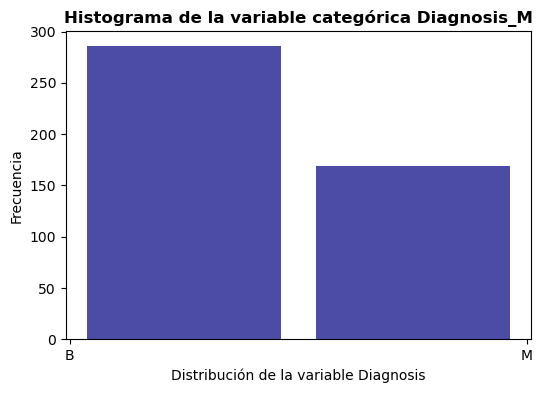

In [18]:
# Histograma de Y_train (variable binaria)
Y_train = Y_train.astype(int)

plt.figure(figsize=(6, 4))
plt.hist(Y_train.values, bins=2, color='navy', alpha=0.7, rwidth=0.85)
plt.xlabel('Distribución de la variable Diagnosis')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['B', 'M'])
plt.title('Histograma de la variable categórica Diagnosis_M', fontweight='bold')
plt.show()


- **Sobremuestreo**

La técnica que hemos escogido para abordar el problema de desequilibrio visto anteriormente es el sobremuestreo (oversamplig).

Teniamos esta frecuencia en cada clase:
Frecuencia de cada clase: 'B' con 375 muestras y 'M' con 212 muestas. La tecnica de sobremuestreo aumentará la cantidad de muestras de la clase menos frecuente, 'M', mediante la replicación y generación de ejemplos.

También se podrían utilizar técnicas de submuestreo, poderación de pesos, etc.



In [19]:
oversampler = RandomOverSampler(random_state=42)
# Aplicar el sobremuestreo
X_train, Y_train = oversampler.fit_resample(X_train, Y_train)

In [20]:
class_distribution = pd.Series(Y_train).value_counts()
print("Técnicas de sobremuestreo:\n")
print(class_distribution)

Técnicas de sobremuestreo:

diagnosis_M
0    286
1    286
Name: count, dtype: int64


- **Normalización y estandarización**

La estandarización es necesaria para que las caracteristicas tengan la misma escala. Utilizamos **StandardScaler** para este trabajo donde todas las variables tendran una media de 0 y una desviación estándar de 1.

In [21]:
# Crear un objeto StandardScaler, el scaler esta definido en el apartado libreria es comun para los tres procesos en los que se necesita
# Ajustar y transformar los datos de entrenamiento
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X_train_dig.columns)

- **Distribución de la variable X_train**

Representación de la distribución de una variable antes y después de realizar su estandarización. La distirbución estandarizada deben ser valores centrados en cero, la desviación estándar aproximadamente de 1 y debe tener una distribución simétrica a la distribución sin estandarizar.

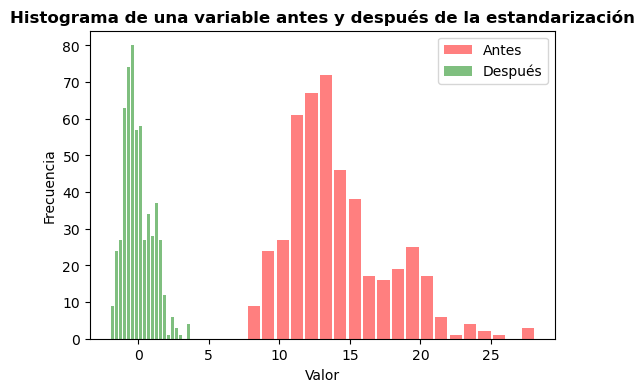

In [22]:
plt.figure(figsize=(6, 4))
plt.hist(X_train_dig.iloc[:, 0], bins=20, color='red', alpha=0.5, rwidth=0.85, label='Antes')
plt.hist(X_train.iloc[:, 0], bins=20, color='green', alpha=0.5, rwidth=0.85, label='Después')

plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de una variable antes y después de la estandarización', fontweight='bold')

plt.legend()

plt.show()

- **Tratamiento de Outliers**

El tratamiento de outliers ayuda a identificar y corregir los valores atípicos de nuestro conjunto de datos. Así mejoramos la calidad de la información y garantizamos que estos valores no influyan en las conclusiones o predicciones.

Definimos en primer lugar una función que elimine los outliers. Hemos decidido determinar el coeficiente de permisividad a 3, es decir, los outliers que se eliminan son valores extremadamente atípicos.

In [23]:
def eliminar_outliers(data, threshold=1.5):
    data_sin_outliers = data.copy()  # Copia el DataFrame original

    for column in data.columns:
        # Calcula los límites para la columna actual
        Q1 = np.percentile(data[column], 25)
        Q3 = np.percentile(data[column], 75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - threshold * IQR
        limite_superior = Q3 + threshold * IQR

        outliers = data_sin_outliers[(data_sin_outliers[column] < limite_inferior) | (data_sin_outliers[column] > limite_superior)]
        data_sin_outliers = data_sin_outliers[(data_sin_outliers[column] >= limite_inferior) & (data_sin_outliers[column] <= limite_superior)]

    return data_sin_outliers

Representación de los datos antes de eliminar los outliers.

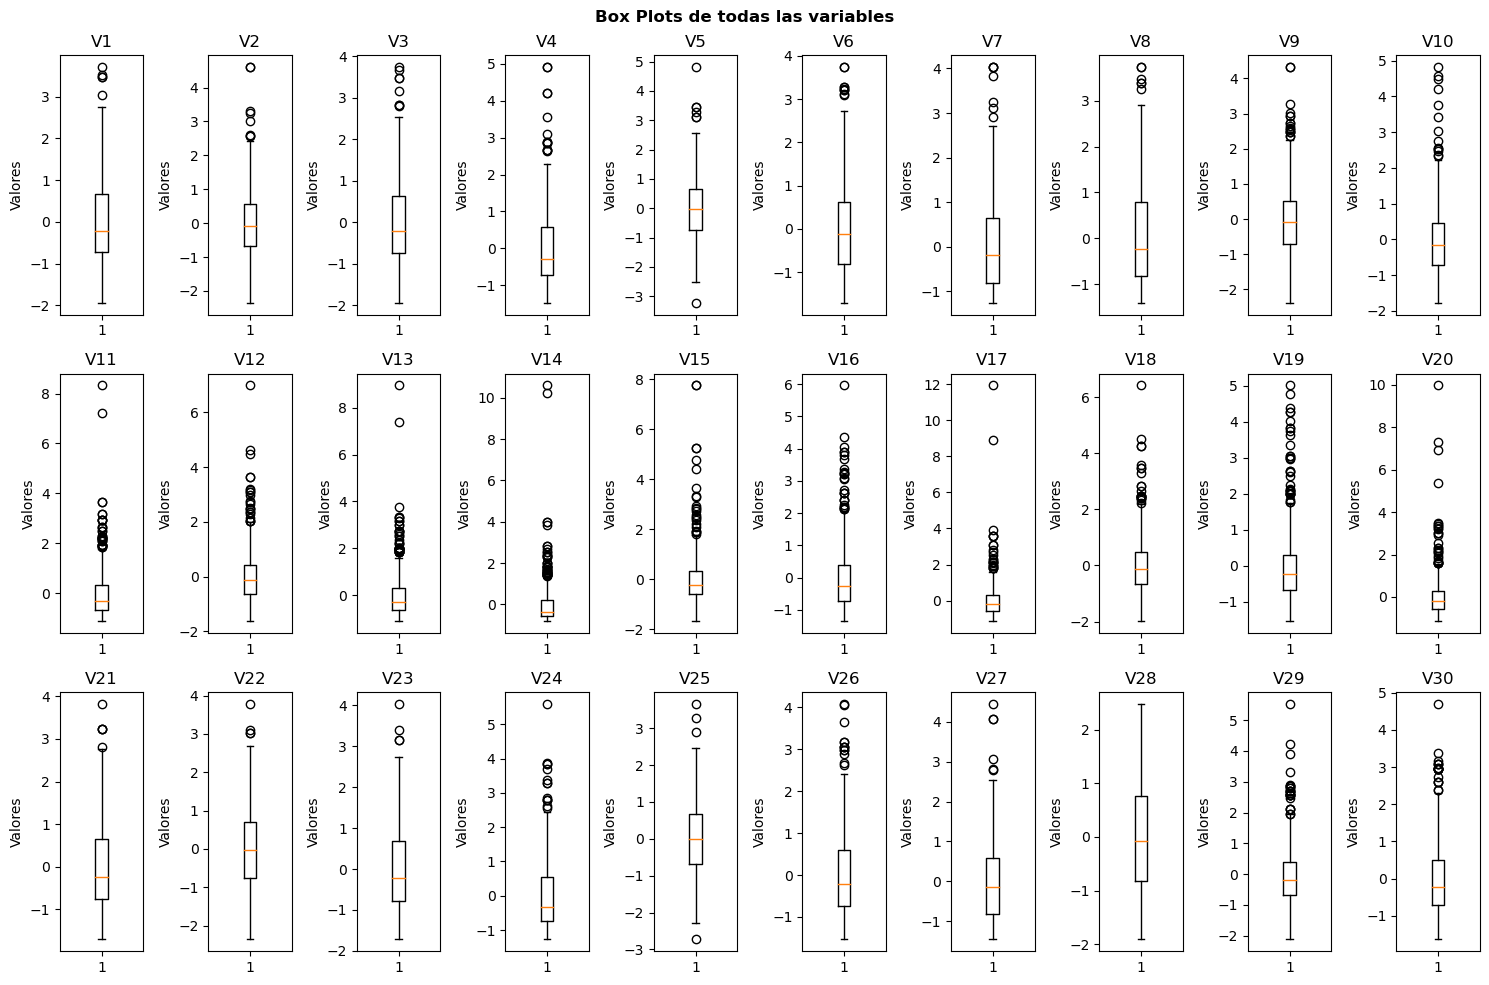

In [24]:
nrows = 3
ncols = 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
for i, var in enumerate(X_train_dig.columns):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.boxplot(X_train[var])
    ax.set_title(var)
    ax.set_ylabel('Valores')

plt.suptitle('Box Plots de todas las variables', fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
#Combinamos las variables predictoras y objetivo
combined_train = pd.concat([X_train, Y_train], axis=1)

In [26]:
#Llamamos a la función para eliminar outliers
combined_train_sin_outliers = eliminar_outliers(combined_train)

In [27]:
Y_train= combined_train_sin_outliers['diagnosis_M']
X_train= combined_train_sin_outliers.drop(['diagnosis_M'], axis=1, inplace=False)

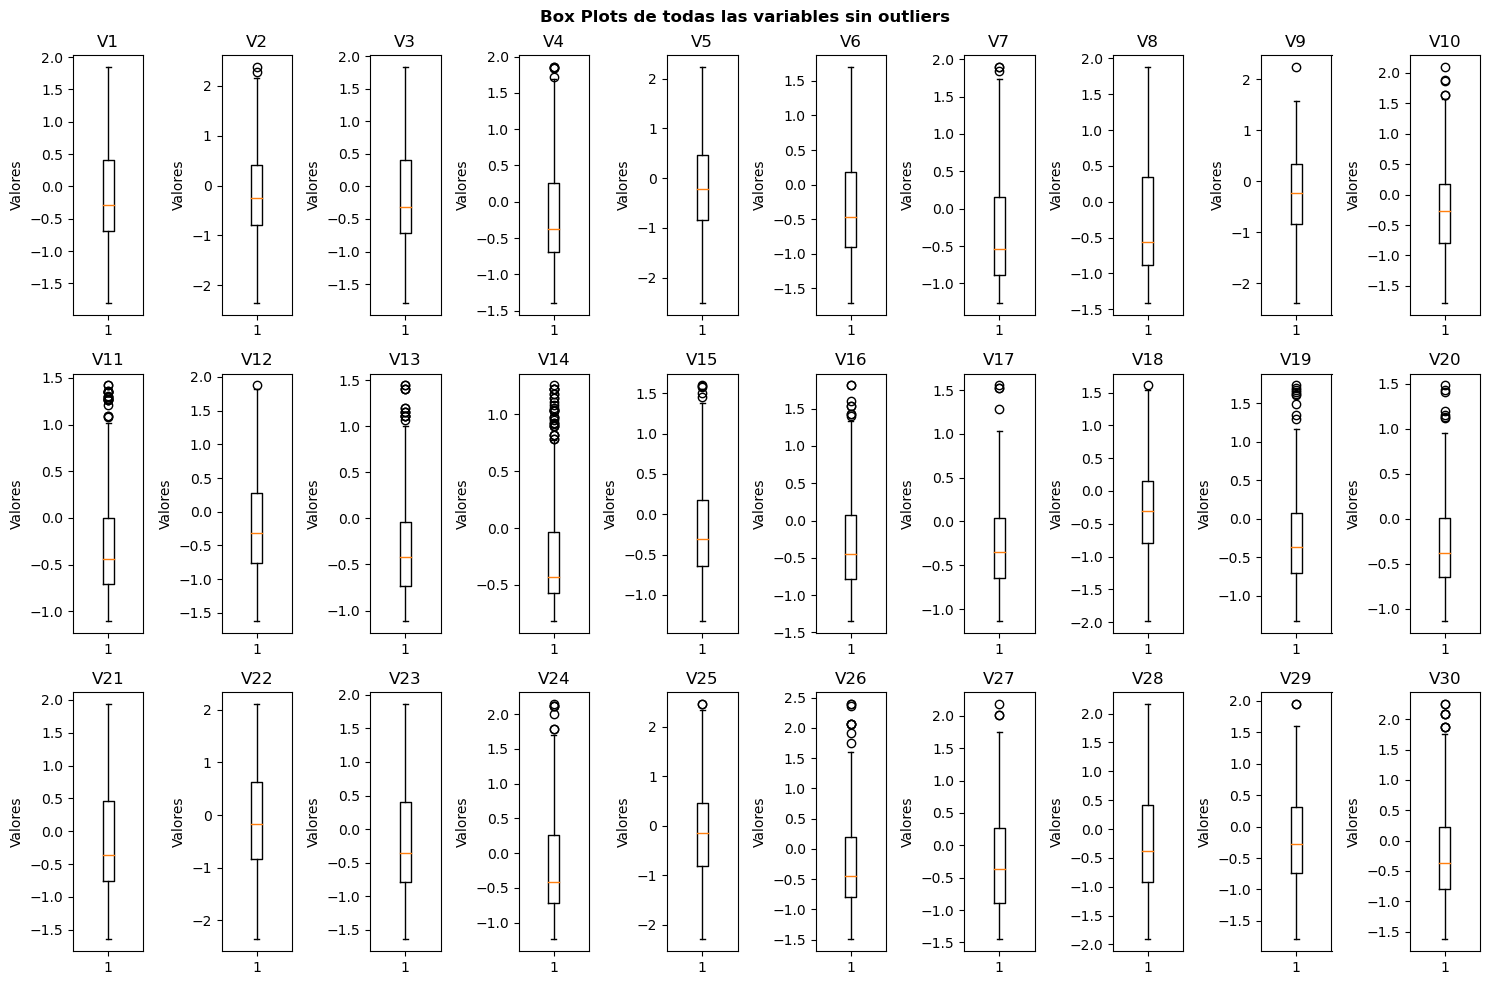

In [28]:
nrows = 3
ncols = 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
for i, var in enumerate(X_train.columns):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    ax.boxplot(X_train[var])
    ax.set_title(var)
    ax.set_ylabel('Valores')

plt.suptitle('Box Plots de todas las variables sin outliers', fontweight='bold')
plt.tight_layout()
plt.show()

### Preprocesado y manipulación del conjunto de evaluación

In [29]:
test = test_dig.copy()

In [30]:
test.head()

,diagnosis,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
204,B,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,M,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,M,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,B,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,B,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


- **Manejo de datos faltantes**

Comprobamos si existen datos faltantes en el conjutno de evaluacion, de ser así deberíamos elaborar técnicas que eliminen o imputen estas caracteristicas. Por ejemplo, basandose en los valores resultantes del manejo de datos faltantes en la etapa de entrenamiento o eliminando las filas o columnas con datos faltantes.

Como ni en el conjunto de evaluación ni en el conjunto de entrenamiento observamos datos faltantes, no hace falta que desarrollemos ninguna técnica anterior.

In [31]:
valores_faltantes_por_variable = test.isnull().sum()
variables_con_valores_faltantes = valores_faltantes_por_variable[valores_faltantes_por_variable > 0]
print(variables_con_valores_faltantes)

Series([], dtype: int64)


- **Codificación de variables categóricas**

Es necesario realizar la codificación de variables categóricas en el conjutno de test para garantizar a los modelos que utilizamos más adelante la capacidad de hacer predicciones coherentes y precisas sobre estos datos.

In [32]:
test = pd.get_dummies(test, columns=["diagnosis"], drop_first=True)
test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,diagnosis_M
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750,False
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589,True
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019,True
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359,False
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134,False


- **Normalización y estandarización**

La estandarización también se lleva a cabo en el conjunto de evaluación para otorgar a los modelso siguientes la capacidad de generalización de los datos no vistos. En esta etapa es esencial aplicar la misma escala de normalización que en el conjunto de entrenamiento.

In [33]:
Y_test = test[['diagnosis_M']]
X_test = test.drop(['diagnosis_M'], axis=1, inplace=False)
X_test = scaler.transform(X_test)


### Métodos de reducción de dimensionalidad o de volumen de datos

En este apartado vamos a intentar reducir o filtrar datos que puedan estar correlacionados o que no aporten valor significativo al entrenamiento del modelo.

- **Selección de variables significativas**

El proceso de selección de variables significativas lo realizamos con el cálculo de p-valor. Obtenemos de cada variable predictoa este atributo, que indica la probabilidad de que la variable no tenga efecto significativo en la respuesta, y nos quedamos con aquellos que sean menores a un umbral. El umbral escogido es 0.05.

In [34]:
X_train_VA = sm.add_constant(X_train)
model = sm.OLS(Y_train, X_train_VA).fit()
print(model.summary())
print()
p_values = model.pvalues
nivel_significancia = 0.05
variables_significativas= p_values[p_values < nivel_significancia].index.values
variables_no_significativas = p_values[p_values >= nivel_significancia].index.values
print("Variables significativas:")
print(variables_significativas)
while len(variables_no_significativas)>0:
    print()
    print()
    print()
    X = X_train_VA[variables_significativas[1:]]
    X = sm.add_constant(X)
    model = sm.OLS(Y_train, X).fit()
    print(model.summary())
    print()
    p_values = model.pvalues
    nivel_significancia = 0.05
    variables_significativas= p_values[p_values < nivel_significancia].index.values
    variables_no_significativas = p_values[p_values >= nivel_significancia].index.values
    print("Variables significativas:")
    print(variables_significativas)

                            OLS Regression Results                            
Dep. Variable:            diagnosis_M   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     43.12
Date:                Wed, 25 Oct 2023   Prob (F-statistic):          1.99e-103
Time:                        18:47:07   Log-Likelihood:                 11.265
No. Observations:                 411   AIC:                             39.47
Df Residuals:                     380   BIC:                             164.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5456      0.017     31.443      0.0

In [35]:
X_train_VA = X_train_VA[variables_significativas[1:]]

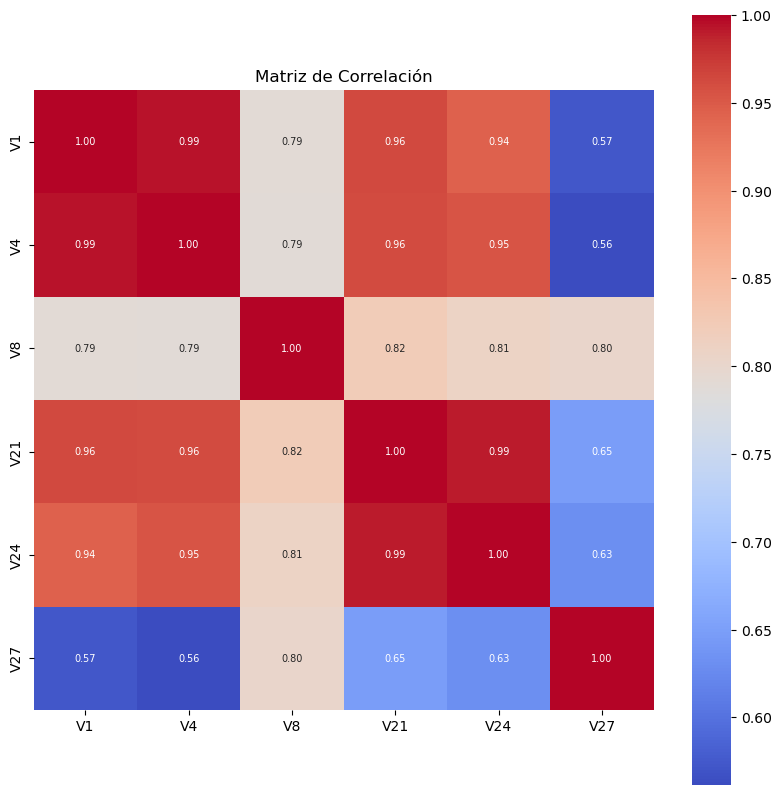

In [36]:
#Matriz de correlación
correlation_matrix = X_train_VA.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 7})
plt.title('Matriz de Correlación')
plt.show()

In [37]:
highly_correlated_pairs = []
threshold = 0.7
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(pair)
print(highly_correlated_pairs)

[('V4', 'V1'), ('V8', 'V1'), ('V8', 'V4'), ('V21', 'V1'), ('V21', 'V4'), ('V21', 'V8'), ('V24', 'V1'), ('V24', 'V4'), ('V24', 'V8'), ('V24', 'V21'), ('V27', 'V8')]


- **Reducción de dimensionalidad con PCA**

Vamos a emplear una de las técnicas de reducción de dimensionalidad para resumir y simplificar los datos, pero manteniendo la variabilidad del conjutno de datos. Utilizamos PCA, Análisis de Componentes Principales.

In [38]:
X_pca_train = X_train.copy()

In [39]:
#scaler = StandardScaler() definimos un scaler comun en el apartado de libreria
X_pca_scaled = scaler.fit_transform(X_pca_train)
aux_pca = PCA()
aux_pca.fit(X_pca_scaled)
varianza_explicada = aux_pca.explained_variance_ratio_
varianza_acumulada_explicada = np.cumsum(varianza_explicada)
pct = 0.95
n_comp = np.argmax(varianza_acumulada_explicada >= pct) + 1

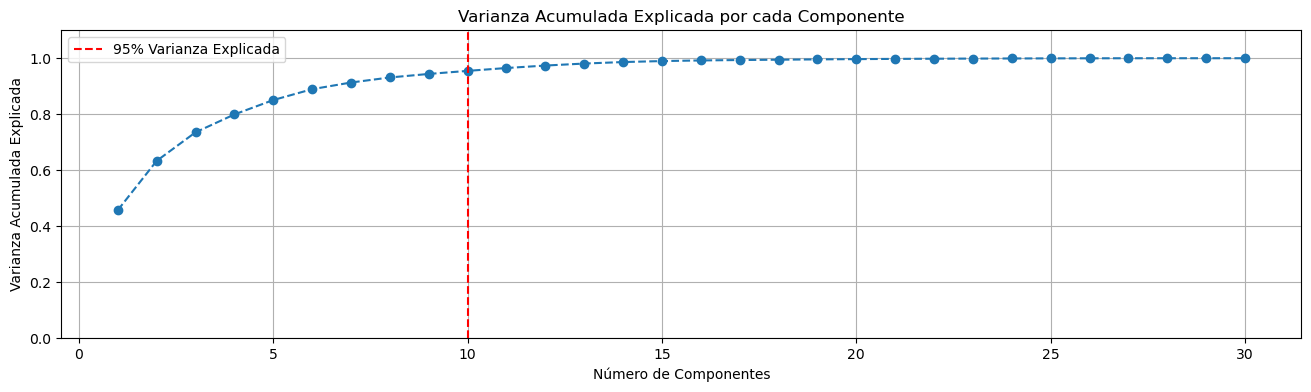


Número de componentes para explicar un 95.0% de la varianza: 10


In [40]:
plt.figure(figsize=(16,4))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_acumulada_explicada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Varianza Acumulada Explicada por cada Componente')
plt.grid()
plt.axvline(x=n_comp, color='red', linestyle='--', label='95% Varianza Explicada')
plt.legend()
plt.ylim(0,1.1)
plt.savefig("figure_name.png", transparent=True)
plt.show()
print()
print(f'Número de componentes para explicar un {pct*100}% de la varianza: {n_comp}')



In [41]:
pca = PCA(n_components=n_comp)
X_pca_train = pca.fit_transform(X_pca_scaled)

In [42]:
X_pca_test = pca.transform(X_test)

Como podemos observar, el conjunto de variables utilizadas para los modelos, si decidimos implementar PCA en nuestro proyecto, se reduce a 10 componentes principales que son combinación lineal de las características originales.

- **Reducción de dimensionalidad con Clustering**

Otra manera de reducir la dimensionalidad  del conjunto de datos es utilizar clustering. Con este método se agrupan puntos de datos similares, clusters, para encontrar patrones intrínsecos o estructuras ocultas de los datos.

El **método Elbow** es una técnica de clsuterin para determinar el número óptimo de clusters en el conjunto de datos. Nosotros queremos el mejor cluster que vaya entre 1 y 11.

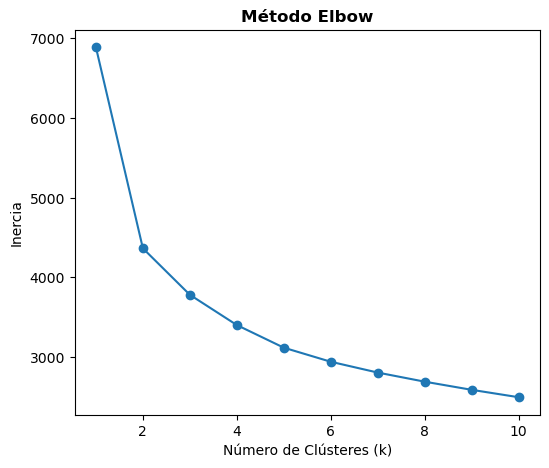

In [43]:
inertia = []
# Rango donde queremos encontrar nuestro cluster
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

# Graficar la curva del codo
plt.figure(figsize=(6, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método Elbow', fontweight='bold')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.show()

Con esta gráfica sabemos que el cluster apropiado para este conjutno de datos es o 3 o 4. Para ser más precisos utilizamos 4 clusters.

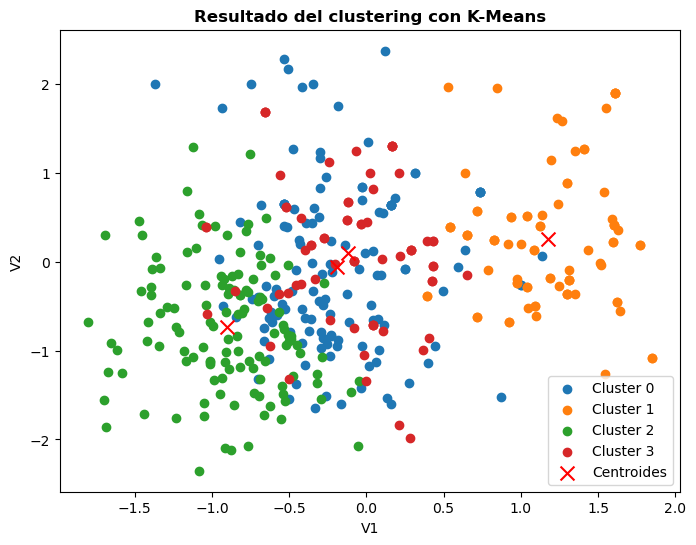

In [44]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_train)
labels = kmeans.labels_
#calculamos las coordenadas de los centroides de los 4 clusters
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(X_train[labels == i]['V1'], X_train[labels == i]['V2'], label=f'Cluster {i}')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='x', label='Centroides')
plt.legend()
plt.title("Resultado del clustering con K-Means", fontweight='bold')
plt.xlabel('V1')
plt.ylabel('V2')
plt.show()


## **2. Metodología con todas las variables**

En esta etapa compararemos de manera efectiva los distintos modelos de regresión, árboles de decisión, K-nn, etc. en términos de su capacidad para predecir el cáncer en el conjunto de datos utilizado.


## 2.1 Regresión Logística



La regresión logística es una técnica utilizada para modelar y predecir la probabilidad de que ocurra uno de dos resultados posibles, generalmente etiquetados como 0 o 1, en función de un conjunto de variables independientes proporcionadas. Esta técnica emplea una función logística que transforma los valores de entrada en un rango de decisión que va desde 0 hasta 1.

------------------------RESULTADOS --------------------------

- Exactitud total del modelo: 0.9736842105263158

 Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.99      0.98        71
        True       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



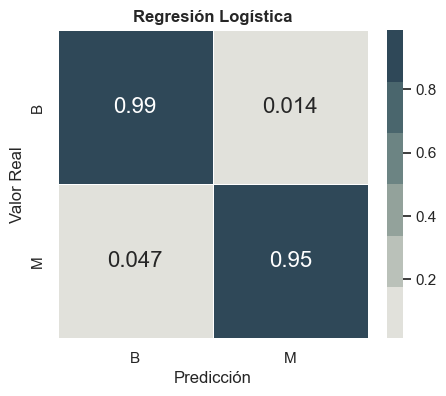

In [45]:
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_lr)
confusion_lr_sin_pca = confusion_matrix(Y_test, y_pred_lr, normalize='true')
report = classification_report(Y_test, y_pred_lr)

# Define the custom palette using the provided hex codes
custom_cmap = ["#E1E1DB", "#BAC1B9", "#93A29B", "#6C8483", "#4A666D", "#2F4858"]
custom_cmap2 = ['#E1E1DB', '#C2C7BC', '#A2AD9F', "#7F9586", "#5C7E71", "#37675F"]

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(confusion_lr_sin_pca, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Regresión Logística', fontweight='bold')
plt.savefig("logistic.png", transparent=True)


print("------------------------RESULTADOS --------------------------\n")
print("- Exactitud total del modelo:",accuracy)
print("\n Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

--------------------CURVA ROC:-----------------------



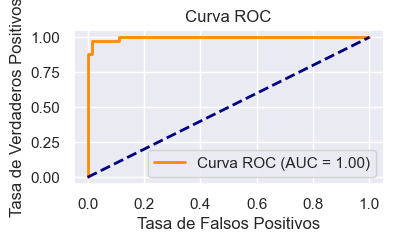

In [46]:
# Calcula la curva ROC y el AUC
y_pred_prob_lr_sin_pca = model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_lr_sin_pca)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
print("--------------------CURVA ROC:-----------------------\n")
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



## 2.2 Análisis Discriminante



Esta técnica tiene como objetivo encontrar combinaciones lineales de las variables independientes que permitan diferenciar entre dos o más grupos.

--------------------RESULTADOS --------------------------

- Exactitud total del modelo: <function accuracy_score at 0x12f9c3b00>

 Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.94      0.96        71
        True       0.91      0.95      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



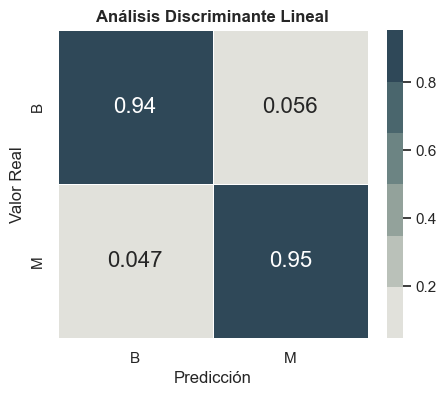

In [47]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
y_pred_lda = lda.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred_lda)
confusion_lda = confusion_matrix(Y_test, y_pred_lda, normalize='true')
report = classification_report(Y_test, y_pred_lda)


plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(confusion_lda, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Análisis Discriminante Lineal', fontweight='bold')
plt.savefig("lda.png", transparent=True)

print("--------------------RESULTADOS --------------------------\n")
print("- Exactitud total del modelo:",accuracy_score)
print("\n Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")


--------------------CURVA ROC:-----------------------



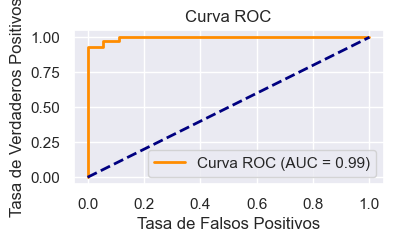

In [48]:
# Calcula la curva ROC y el AUC
y_pred_prob_lda = lda.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_lda)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


## 2.3 k-Nearest Neighboors (KNN)



Este algoritmo plantea la idea de que los ejemplos que están cerca en el espacio de caracteristicas tienden a tener etiquetas o valores similares.

Se utiliza además GridSeachCV que encuentra la combinación de hiperparámtros que optimiza el rendimiento de nuestro modelo KNN.  Combinado con el empleo de **Validación Cruzada** (cv=5) que divide el conjunto de datos en pliegues para evaluar el modelo en múltiples subconjutnos y obtener un mejor rendimiento.

Mejores hiperparámetros: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


-------------------RESULTADOS --------------------------

- Exactitud total del modelo: <function accuracy_score at 0x12f9c3b00>

 Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        71
        True       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



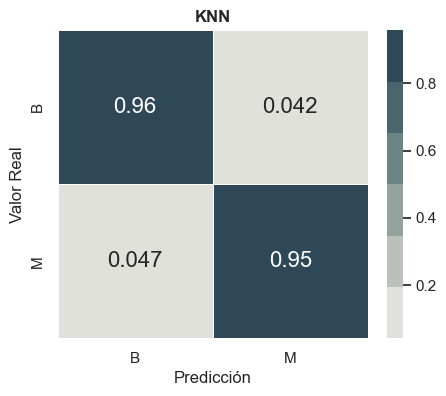

In [49]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

f1_weighted_scorer = make_scorer(f1_score, average='weighted')

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=f1_weighted_scorer)

grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
y_pred_knn = grid_search.predict(X_test)
f1_score_test = f1_score(Y_test, y_pred_knn, average='weighted')
print()
print()
accuracy = accuracy_score(Y_test, y_pred_knn)
confusion_knn = confusion_matrix(Y_test, y_pred_knn, normalize='true')
report = classification_report(Y_test, y_pred_knn)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(confusion_knn, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('KNN', fontweight='bold')
plt.savefig("knn.png", transparent=True)

print("-------------------RESULTADOS --------------------------\n")
print("- Exactitud total del modelo:",accuracy_score)
print("\n Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

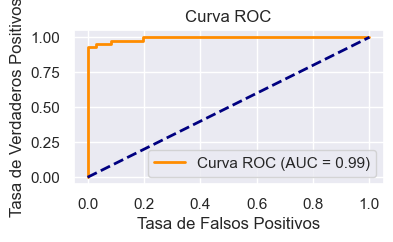

In [50]:
# Calcula la curva ROC y el AUC
y_pred_prob_knn = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Como complemento para esta técnica y entender por qué el mejor hiperparámetro es el valor de k=5, representamos la tasa de error en función de k que nos permite analizar los valores óptimos de k.

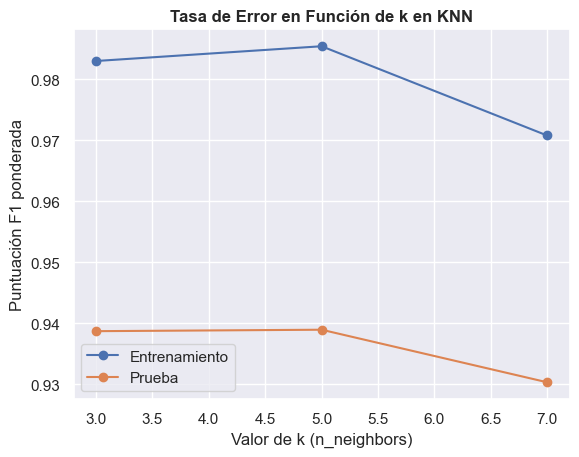

In [51]:
k_values = [3, 5, 7]
train_scores = []
test_scores = []

for k in k_values:
    # Crea y ajusta el modelo KNN con el valor actual de k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y prueba
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    train_f1 = f1_score(Y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(Y_test, y_test_pred, average='weighted')

    train_scores.append(train_f1)
    test_scores.append(test_f1)

# Trama las puntuaciones
plt.figure()
plt.plot(k_values, train_scores, marker='o', label='Entrenamiento')
plt.plot(k_values, test_scores, marker='o', label='Prueba')
plt.xlabel('Valor de k (n_neighbors)')
plt.ylabel('Puntuación F1 ponderada')
plt.title('Tasa de Error en Función de k en KNN', fontweight='bold')
plt.legend()
plt.show()

Nos aparece que k=5 tiene una tasa de f1-score en train del 0.99 mientras que en test es de 0.94. Esta dupla de valores es la mejor a tener en cuenta.


## 2.4 Métodos basados en árboles



Los métodos que veremos a continuación están basados en estructura de árbol para la toma de decisiónes.

- Árbol de clasificación

La estructura jerárquica más simple para la toma de decisiones en un clasificador.

-----RESULTADOS --------------------------

- Exactitud total del modelo: 0.9122807017543859
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        71
        True       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



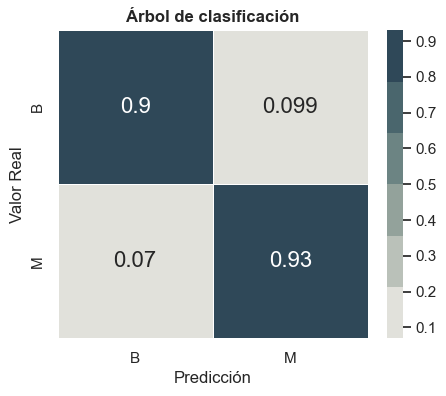

In [52]:
decision_tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=42)
decision_tree.fit(X_train, Y_train)
y_pred_dt = decision_tree.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_dt)
conf_matrix = confusion_matrix(Y_test, y_pred_dt, normalize='true')
classification_rep = classification_report(Y_test, y_pred_dt)

custom_cmap = sns.color_palette(custom_cmap,as_cmap=True)
plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Árbol de clasificación', fontweight='bold')
plt.savefig("decisiontree.png", transparent=True)

print("-----RESULTADOS --------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

--------------------CURVA ROC:-----------------------



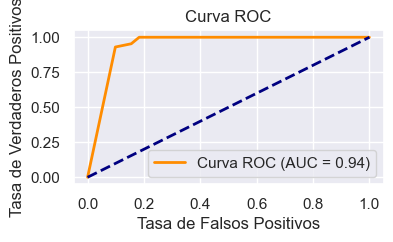

In [53]:
# Calcula la curva ROC y el AUC
y_pred_prob_knn = decision_tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

- **Representación gráfica del árbol de decisión.**

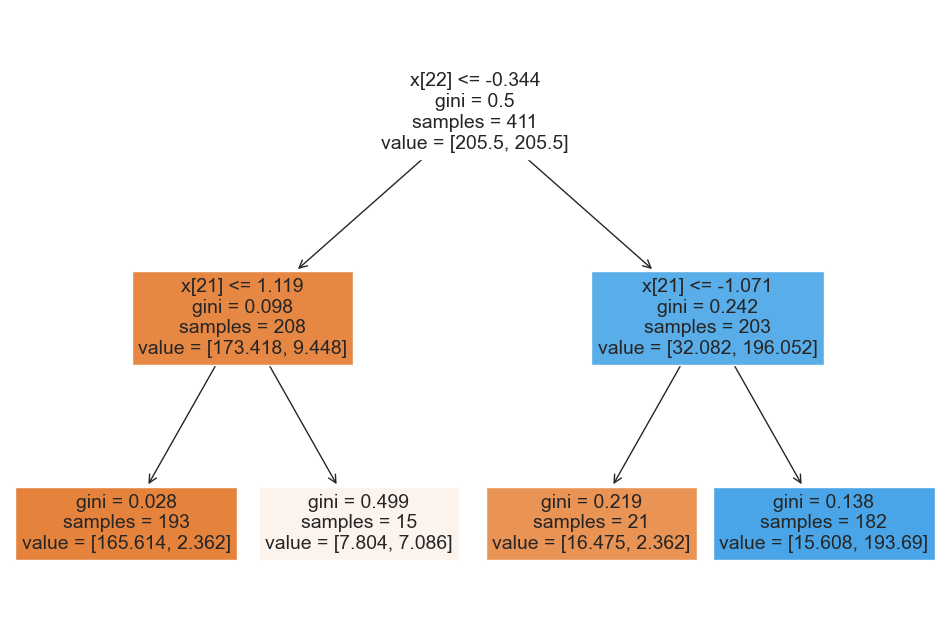

In [54]:
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, filled=True)
plt.show()

- Árbol con bagging

En este enfoque se combinan múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste.

-----RESULTADOS --------------------------

- Exactitud total del modelo: 0.9649122807017544
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        71
        True       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



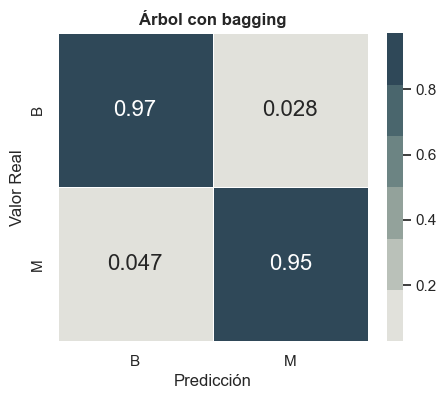

In [55]:
# Crea un árbol de decisión como estimador base
base_estimator = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)
bagging_model.fit(X_train, Y_train)


y_pred_bag = bagging_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_bag)
conf_matrix_bag = confusion_matrix(Y_test, y_pred_bag, normalize='true')
classification_rep = classification_report(Y_test, y_pred_bag)

custom_cmap = sns.color_palette(custom_cmap,as_cmap=True)
plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_bag, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Árbol con bagging', fontweight='bold')
plt.savefig("bagging_tree.png", transparent=True)

print("-----RESULTADOS --------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")


--------------------CURVA ROC:-----------------------



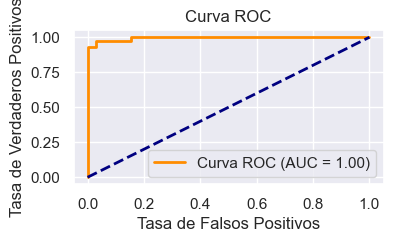

In [56]:
# Calcula la curva ROC y el AUC
y_pred_prob_knn = bagging_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

- Random Forest

Este modelo es una extensión de los árboles de decisión y se basa en un conjunto de árboles que mejoran la precisión del modelo. Random Forest es una implementación de Bagging que se centra en el uso de árboles de decisión.

En esta sección aprovecharemos para utilizar técnicas de remuestreos como Bootstrap o validación cruzada.

 *Random Forest con Bootstrap*

Bootstrap toma múltiples muestras con reemplazo del conjunto de datos original.

--------------RESULTADOS ---------

- Exactitud total del modelo: 0.9736842105263158
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        71
        True       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



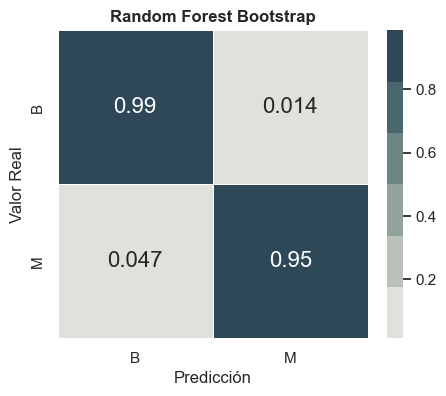

In [57]:
# Crear un modelo Random Forest
rf_boot = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
rf_boot.fit(X_train, Y_train)
y_pred_rf_boot = rf_boot.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_rf_boot)
conf_matrix_rf_boot_sin_pca = confusion_matrix(Y_test, y_pred_rf_boot, normalize='true')
classification_rep = classification_report(Y_test, y_pred_rf_boot)


plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_rf_boot_sin_pca, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Random Forest Bootstrap', fontweight='bold')
plt.savefig("randomforest_bootstrap.png", transparent=True)

print("--------------RESULTADOS ---------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

--------------------CURVA ROC:-----------------------



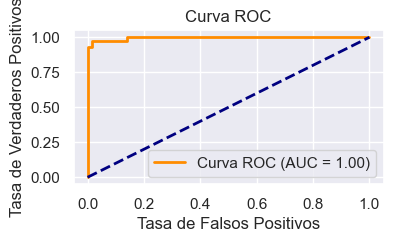

In [58]:
# Calcula la curva ROC y el AUC
y_pred_prob_boot_sin_pca = rf_boot.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_boot_sin_pca)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Random Forest con Validación Cruzada

La técnica de validación cruzada divide el conjunto de datos en múltiples folds, en 5 más concretamente, entrenas y evaluas el modelo en estos subconjuntos.

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')
-------------------RESULTADOS -------------------------------

- Exactitud total del modelo: 0.956140350877193
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        71
        True       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



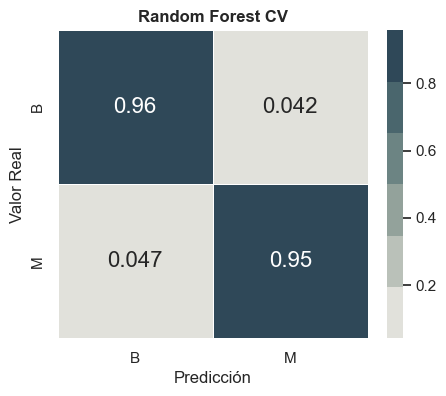

In [59]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

rf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, Y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(best_rf)

accuracy = accuracy_score(Y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(Y_test, y_pred_rf, normalize='true')
classification_rep = classification_report(Y_test, y_pred_rf)


plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_rf, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Random Forest CV', fontweight='bold')
plt.savefig("random_forest_cv.png", transparent=True)


print("-------------------RESULTADOS -------------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")


--------------------CURVA ROC:-----------------------



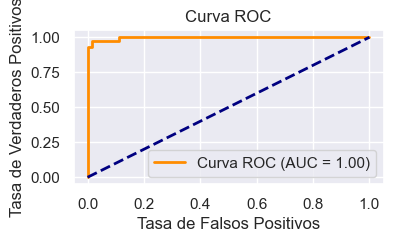

In [60]:
# Calcula la curva ROC y el AUC
y_pred_prob_knn = grid_search_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

- Gradient Boosting

Este modelo combina múltiples modelos débiles secuenciales y durante el entrenamiento corrige el error del modelo anterior.

------------------------RESULTADOS---------------------------

- Exactitud total del modelo: 0.9649122807017544
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.96      0.96        71
        True       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



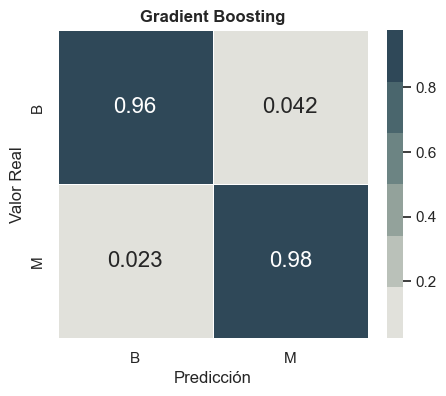

In [61]:
# Crear un modelo Gradient Boosting para clasificación
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train,Y_train)
y_pred_gb = gb.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(Y_test, y_pred_gb, normalize='true')
classification_rep = classification_report(Y_test, y_pred_gb)


plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_gb, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Gradient Boosting', fontweight='bold')
plt.savefig("gradientboosting.png", transparent=True)

print("------------------------RESULTADOS---------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

--------------------CURVA ROC:-----------------------



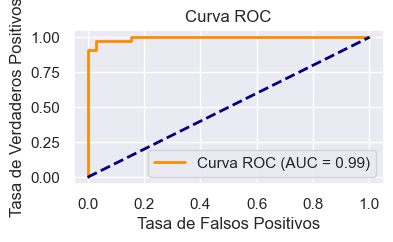

In [62]:
# Calcula la curva ROC y el AUC
y_pred_prob_knn = gb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## **3. Metodología utilizando PCA para reducción de dimensionalidad**

En esta etapa compararemos de manera efectiva los distintos modelos de regresión, árboles de decisión, K-nn, etc. en términos de su capacidad para predecir el cáncer en el conjunto de datos utilizado.


## 3.1 Regresión Logística



-----------------RESULTADOS----------------------------------

- Exactitud total del modelo: <function accuracy_score at 0x12f9c3b00>

 Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.97      0.99      0.98        71
        True       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



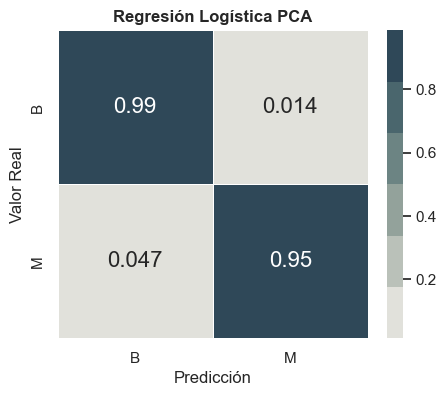

In [63]:
model_lr = LogisticRegression()
model_lr.fit(X_pca_train, Y_train)
y_pred_lr = model_lr.predict(X_pca_test)
accuracy = accuracy_score(Y_test, y_pred_lr)
confusion_lr = confusion_matrix(Y_test, y_pred_lr, normalize='true')
report = classification_report(Y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(confusion_lr, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Regresión Logística PCA', fontweight='bold')
plt.savefig("logistic_pca.png", transparent=True)

print("-----------------RESULTADOS----------------------------------\n")
print("- Exactitud total del modelo:",accuracy_score)
print("\n Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

--------------------CURVA ROC:-----------------------



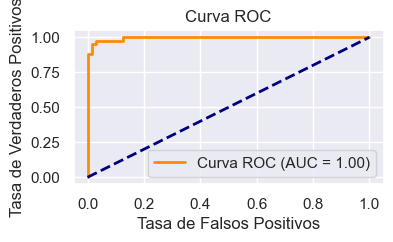

In [64]:
# Calcula la curva ROC y el AUC
y_pred_prob_lr = model_lr.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_lr)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
print("--------------------CURVA ROC:-----------------------\n")
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()



## 3.2 Análisis Discriminante



-------------------------RESULTADOS ---------------------------

- Exactitud total del modelo: <function accuracy_score at 0x12f9c3b00>

 Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.90      1.00      0.95        71
        True       1.00      0.81      0.90        43

    accuracy                           0.93       114
   macro avg       0.95      0.91      0.92       114
weighted avg       0.94      0.93      0.93       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



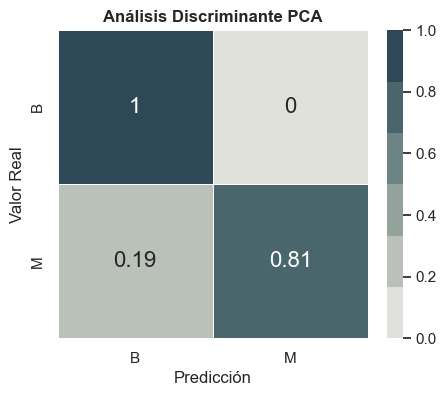

In [65]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_pca_train, Y_train)
y_pred_lda = lda.predict(X_pca_test)

accuracy = accuracy_score(Y_test, y_pred_lda)
confusion_lda = confusion_matrix(Y_test, y_pred_lda, normalize='true')
report = classification_report(Y_test, y_pred_lda)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(confusion_lda, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Análisis Discriminante PCA', fontweight='bold')
plt.savefig("lda_pca.png", transparent=True)

print("-------------------------RESULTADOS ---------------------------\n")
print("- Exactitud total del modelo:",accuracy_score)
print("\n Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")


--------------------CURVA ROC:-----------------------



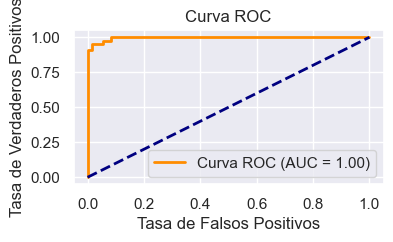

In [66]:
# Calcula la curva ROC y el AUC
y_pred_prob_lda = lda.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_lda)
roc_auc = auc(fpr, tpr)

print("--------------------CURVA ROC:-----------------------\n")
# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


## 3.3 K-Nearest Neighbors (KNN)



Mejores hiperparámetros: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
----------------------RESULTADOS ----------------------------

- Exactitud total del modelo: <function accuracy_score at 0x12f9c3b00>

 Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.89      0.96      0.93        71
        True       0.92      0.81      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



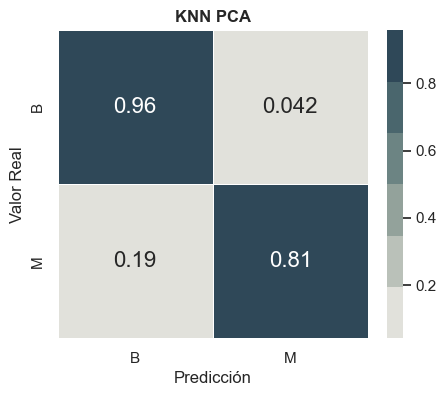

In [67]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

f1_weighted_scorer = make_scorer(f1_score, average='weighted')

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=f1_weighted_scorer)

grid_search.fit(X_pca_train, Y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)
y_pred_knn = grid_search.predict(X_pca_test)
f1_score_test = f1_score(Y_test, y_pred_knn, average='weighted')

accuracy = accuracy_score(Y_test, y_pred_knn)
confusion_knn = confusion_matrix(Y_test, y_pred_knn, normalize='true')
report = classification_report(Y_test, y_pred_knn)

# Configuración de la matriz de Confusión:
plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(confusion_knn, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('KNN PCA', fontweight='bold')
plt.savefig("knn_pca.png", transparent=True)

print("----------------------RESULTADOS ----------------------------\n")
print("- Exactitud total del modelo:",accuracy_score)
print("\n Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

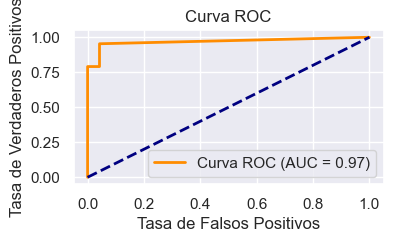

In [68]:
# Calcula la curva ROC y el AUC
y_pred_prob_knn = grid_search.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_knn)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

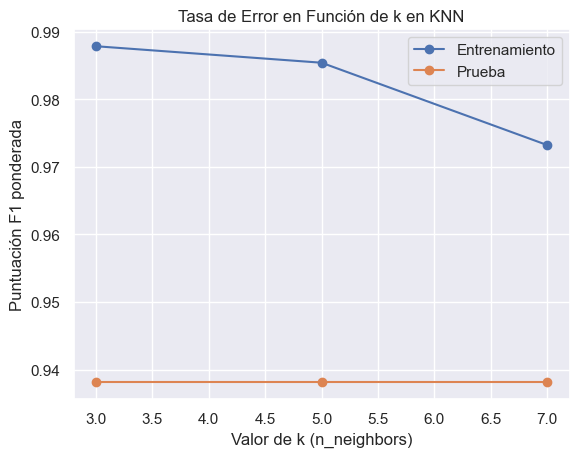

In [69]:
k_values = [3, 5, 7]
train_scores = []
test_scores = []

for k in k_values:
    # Crea y ajusta el modelo KNN con el valor actual de k
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pca_train, Y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y prueba
    y_train_pred = knn.predict(X_pca_train)
    y_test_pred = knn.predict(X_pca_test)

    # Calcula la puntuación F1 ponderada en los conjuntos de entrenamiento y prueba
    train_f1 = f1_score(Y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(Y_test, y_test_pred, average='weighted')

    # Almacena las puntuaciones en las listas
    train_scores.append(train_f1)
    test_scores.append(test_f1)

# Trama las puntuaciones
plt.figure()
plt.plot(k_values, train_scores, marker='o', label='Entrenamiento')
plt.plot(k_values, test_scores, marker='o', label='Prueba')
plt.xlabel('Valor de k (n_neighbors)')
plt.ylabel('Puntuación F1 ponderada')
plt.title('Tasa de Error en Función de k en KNN')
plt.legend()
plt.show()

Los resultados de tasa de f1-score en entrenamiento y error con PCA y sin PCA no varían demasiado dado que el valor óptimo con el que predecimos es el mmismo (k=5).

Comparación de resultados.

```
Sin PCA
k=3, Train F1 Score: 0.98, Test F1 Score: 0.94
k=5, Train F1 Score: 0.99, Test F1 Score: 0.94
k=7, Train F1 Score: 0.98, Test F1 Score: 0.93

-------------------------------------------------
Con PCA
k=3, Train F1 Score: 0.99, Test F1 Score: 0.93
k=5, Train F1 Score: 0.99, Test F1 Score: 0.94
k=7, Train F1 Score: 0.98, Test F1 Score: 0.92
```





## 3.4 Métodos basados en árboles



- Árbol de clasificación

----------------RESULTADOS ----------------------------------

- Exactitud total del modelo: 0.956140350877193
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.89      0.96      0.93        71
        True       0.92      0.81      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



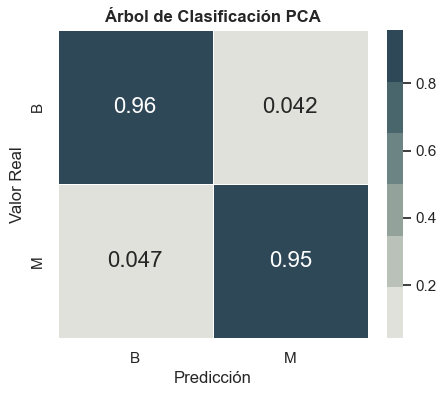

In [70]:
decision_tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=42)
decision_tree.fit(X_pca_train, Y_train)
y_pred_dt = decision_tree.predict(X_pca_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_dt)
conf_matrix = confusion_matrix(Y_test, y_pred_dt, normalize='true')
classification_rep = classification_report(Y_test, y_pred_dt)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Árbol de Clasificación PCA', fontweight='bold')
plt.savefig("decisiontree_pca.png", transparent=True)

print("----------------RESULTADOS ----------------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

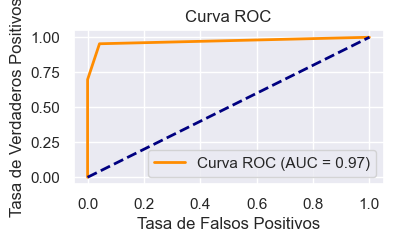

In [71]:
# Calcula la curva ROC y el AUC
y_pred_prob_decision = decision_tree.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_decision)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

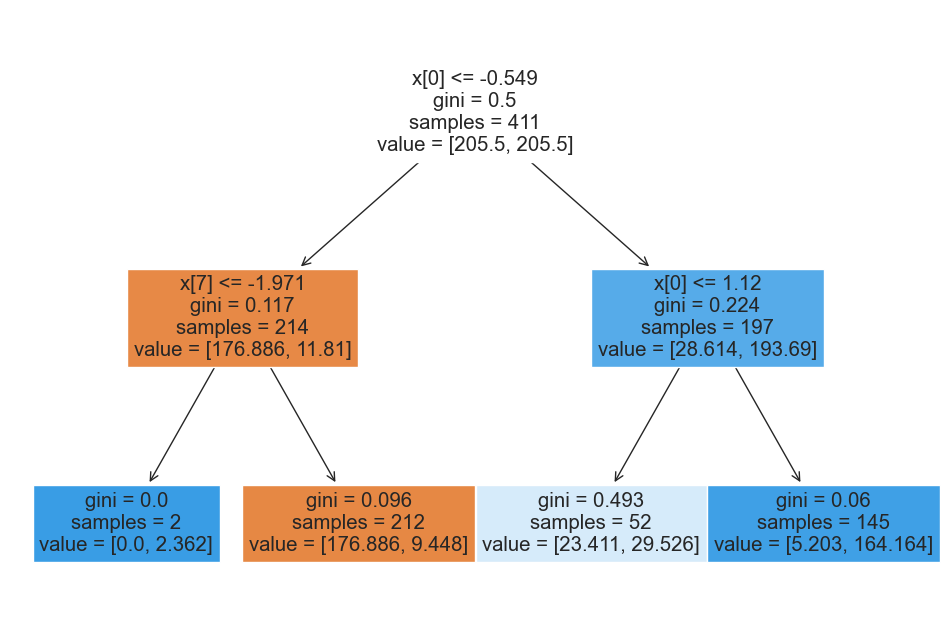

In [72]:
# Dibujar el árbol de clasificación
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, filled=True)
plt.show()

- *Árbol con bagging*

------------------RESULTADOS --------------------------------

- Exactitud total del modelo: 0.9385964912280702
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.89      0.96      0.93        71
        True       0.92      0.81      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



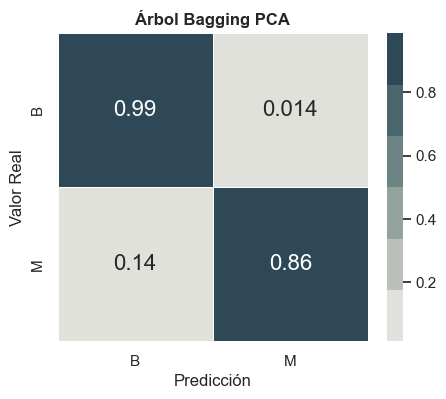

In [73]:
# Crea un árbol de decisión como estimador base
base_estimator = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)
bagging_model.fit(X_pca_train, Y_train)
y_pred_bag = bagging_model.predict(X_pca_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_bag)
conf_matrix_bag = confusion_matrix(Y_test, y_pred_bag, normalize='true')
classification_rep = classification_report(Y_test, y_pred_bag)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_bag, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Árbol Bagging PCA', fontweight='bold')
plt.savefig("bagging_tree_pca.png", transparent=True)

print("------------------RESULTADOS --------------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")


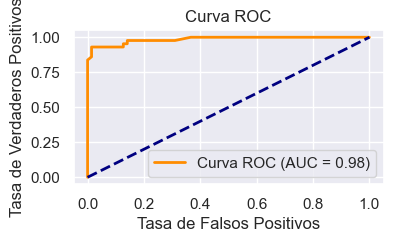

In [74]:
# Calcula la curva ROC y el AUC
y_pred_prob_decision = bagging_model.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_decision)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

- Random Forest

 *Random Forest Bootstrap*

--------------RESULTADOS-------------------------------------

- Exactitud total del modelo: 0.9385964912280702
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.89      0.96      0.93        71
        True       0.92      0.81      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



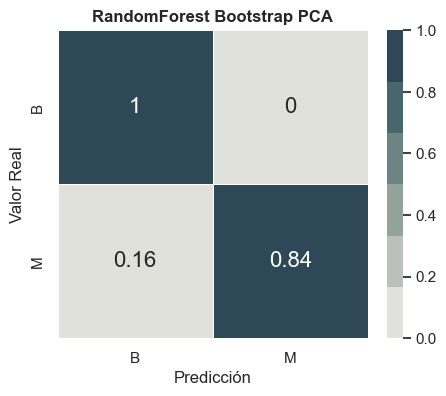

In [75]:
# Crear un modelo Random Forest
rf_boot = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)  # Bootstrap está habilitado de forma predeterminada

rf_boot.fit(X_pca_train, Y_train)
y_pred_rf_boot = rf_boot.predict(X_pca_test)
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_rf_boot)
conf_matrix_rf_boot = confusion_matrix(Y_test, y_pred_rf_boot, normalize='true')
classification_rep = classification_report(Y_test, y_pred_rf_boot)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_rf_boot, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('RandomForest Bootstrap PCA', fontweight='bold')
plt.savefig("randomforest_bootstrap_pca.png", transparent=True)

print("--------------RESULTADOS-------------------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

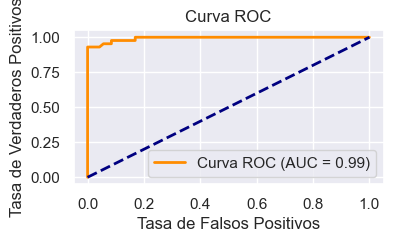

In [76]:
# Calcula la curva ROC y el AUC
y_pred_prob_decision = rf_boot.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_decision)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Random Forest con Validación Cruzada

-----------------RESULTADOS ---------------------------------

- Exactitud total del modelo: 0.9035087719298246
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.89      0.96      0.93        71
        True       0.92      0.81      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



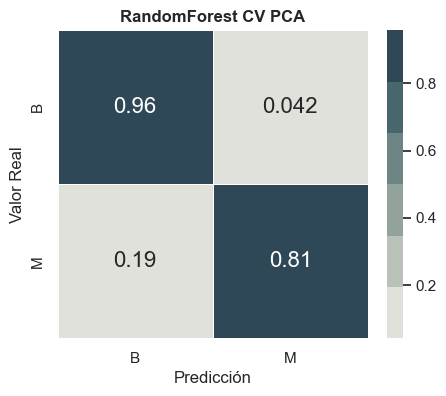

In [77]:
# Definir un rango de valores para los hiperparámetros que deseas ajustar
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30]
}

rf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=False)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_pca_train, Y_train)
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_pca_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(Y_test, y_pred_rf, normalize='true')
classification_rep = classification_report(Y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_rf, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('RandomForest CV PCA', fontweight='bold')
plt.savefig("random_forest_cv_pca.png", transparent=True)

print("-----------------RESULTADOS ---------------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")


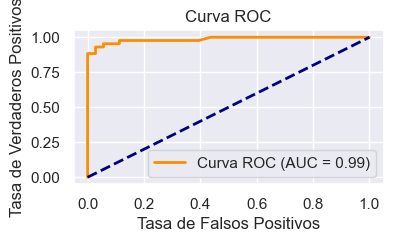

In [78]:
# Calcula la curva ROC y el AUC
y_pred_prob_decision = grid_search_rf.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_decision)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

- Gradient Boosting

----------------------RESULTADOS -----------------------------

- Exactitud total del modelo: 0.9473684210526315
Informe global de clasificación del modelo:
               precision    recall  f1-score   support

       False       0.89      0.96      0.93        71
        True       0.92      0.81      0.86        43

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.89       114
weighted avg       0.90      0.90      0.90       114

--------------------MATRIZ DE CONFUSIÓN-----------------------



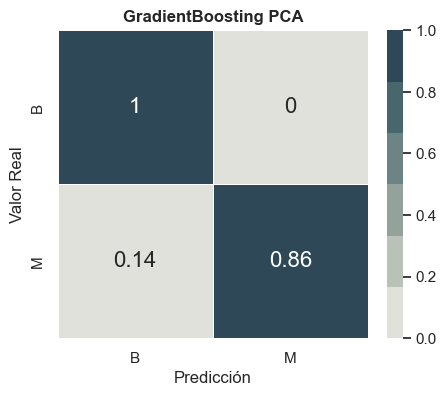

In [79]:
# Crear un modelo Gradient Boosting para clasificación
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_pca_train,Y_train)
y_pred_gb = gb.predict(X_pca_test)


# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(Y_test, y_pred_gb, normalize='true')
classification_rep = classification_report(Y_test, y_pred_gb)

plt.figure(figsize=(5, 4))
sns.set(font_scale=1)
sns.heatmap(conf_matrix_gb, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, xticklabels=['B', 'M'], yticklabels=['B', 'M'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('GradientBoosting PCA', fontweight='bold')
plt.savefig("gradientboosting_pca.png", transparent=True)

print("----------------------RESULTADOS -----------------------------\n")
print("- Exactitud total del modelo:", accuracy)
print("Informe global de clasificación del modelo:\n", report)
print("--------------------MATRIZ DE CONFUSIÓN-----------------------\n")

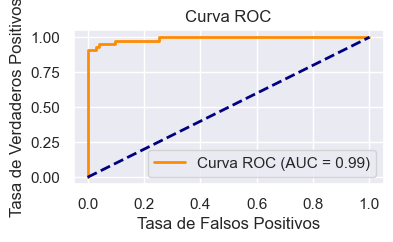

In [80]:
# Calcula la curva ROC y el AUC
y_pred_prob_decision = gb.predict_proba(X_pca_test)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob_decision)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

## **4. Evaluación final de los resultados**

### 4.1 Elección de método para reducir las dimensiones del conjunto de datos

Al examinar los diversas técnicas de reducción y/o simplificación de los datos llegamos a la conclusión de que la simplificación más adecuada era utilizando el Análisis de Componentes Principales (PCA). Este método proyecta los datos en un espacio de menor dimensión utilizando solo 10 componentes principales. Siempre conservando la mayor cantidad de varianza de nuestro conjunto original.

Descartamos la selección de características como una alternativa viable, los resultados obtenidos estaban muy correlacionados lo que dificultaba su aplicación efectiva. Además, aunque reconocemos que el clustering es una técnica valiosa en el análisis de datos, decidimos descartar su implementación para esta tarea.

Representamos el diagrama de dispersión  de PCA donde se describe la distribución de los datos en el espacio bidimensional construido en base a las dos primeras componentes principales.

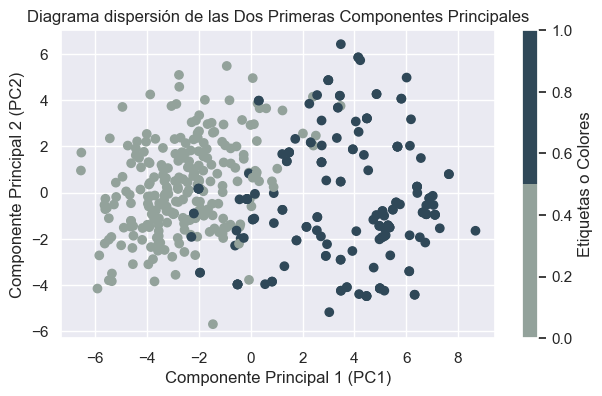

In [81]:
from matplotlib.colors import ListedColormap
custom_cmap_m = ['#93A29B', '#2F4858']
custom_cmap_m = ListedColormap(custom_cmap_m)

plt.figure(figsize=(7, 4))
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=Y_train, cmap=custom_cmap_m)
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.title('Diagrama dispersión de las Dos Primeras Componentes Principales')

# Mostrar etiquetas o colores
cbar = plt.colorbar()
cbar.set_label('Etiquetas o Colores')
plt.savefig("pca.png", transparent=True)
plt.show()

### 4.2 Elección del mejor modelo con y sin PCA.

Comparando las métricas de clasificación entre todos los modelos entrenados seleccionamos dos  muy similares: la regresión logística sin PCA y Random Forest con bootstrap sin PCA. Necesitamos asegurarnos de que en ninguno de los dos modelos existe un sobreajuste.

- **Comparación de sus métricas.**


 **Regresión Logística sin PCA**
```
- Exactitud Total del Modelo: 0.9737

Informe Global de Clasificación del Modelo:

| Clase | Precisión | Recall | F1-Score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.97      | 0.99   | 0.98     | 71      |
| 1     | 0.98      | 0.95   | 0.96     | 43      |

- Exactitud (Accuracy): 0.97
- Promedio Ponderado (Weighted Avg): 0.97

- Promedio Macro (Macro Avg): 0.97


```




 **Random Forest con Bootstrap sin PCA**
```
- Exactitud Total del Modelo: 0.9736

Informe Global de Clasificación del Modelo:

| Clase | Precisión | Recall | F1-Score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.97      | 0.96   | 0.96     | 71      |
| 1     | 0.93      | 0.95   | 0.94     | 43      |

- Exactitud (Accuracy): 0.96
- Promedio Ponderado (Weighted Avg): 0.95

- Promedio Macro (Macro Avg): 0.96
```



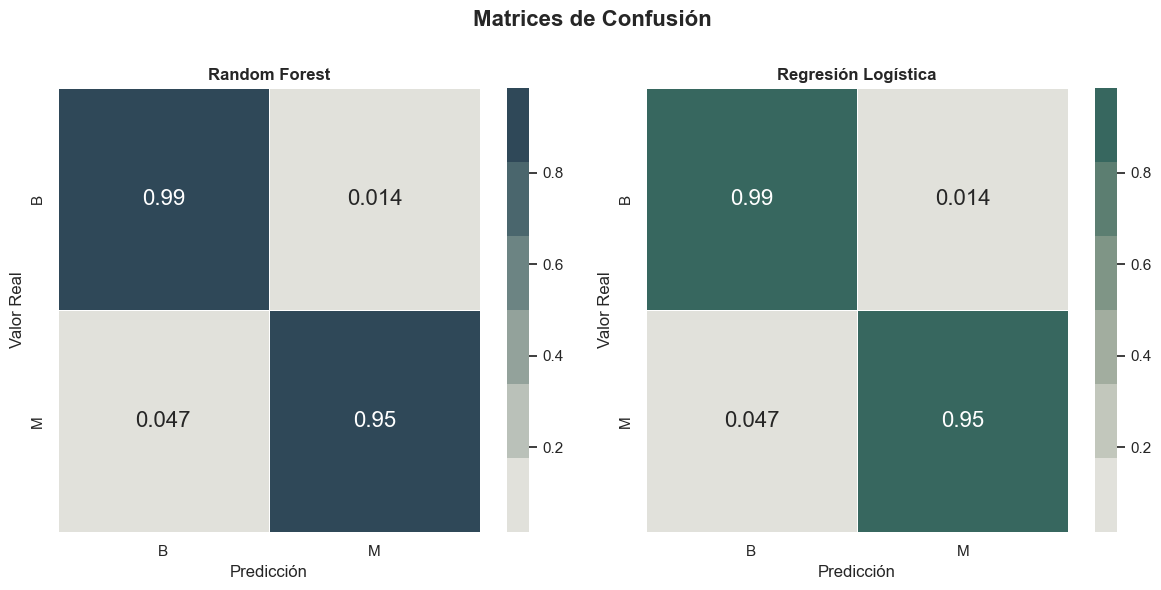

In [82]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.set(font_scale=1)
sns.heatmap(conf_matrix_rf_boot_sin_pca, annot=True, fmt='.2g', cmap=custom_cmap, linewidths=0.5, annot_kws={"size": 16}, ax=axes[0], xticklabels=['B', 'M'], yticklabels=['B', 'M'])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Valor Real')
axes[0].set_title('Random Forest', fontweight='bold')


sns.set(font_scale=1)
sns.heatmap(confusion_lr_sin_pca, annot=True, fmt='.2g', cmap=custom_cmap2, linewidths=0.5, annot_kws={"size": 16}, ax=axes[1], xticklabels=['B', 'M'], yticklabels=['B', 'M'])
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Valor Real')
axes[1].set_title('Regresión Logística', fontweight='bold')


fig.suptitle('Matrices de Confusión', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("figure_name.png", transparent=True)
plt.show()


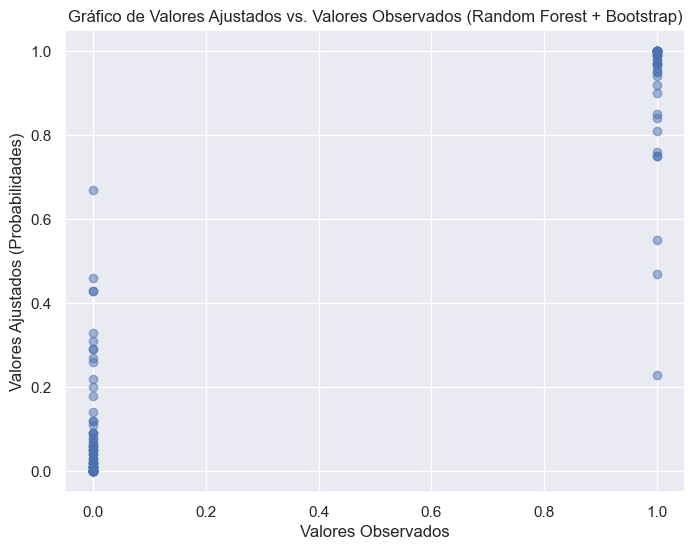

In [83]:
# Crear un modelo Random Forest
rf_boot = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
rf_boot.fit(X_train, Y_train)
y_pred_rf_boot = rf_boot.predict(X_test)

custom_cmap_a = ["#E1E1DB", "#BAC1B9", "#93A29B", "#6C8483", "#4A666D", "#2F4858"]
custom_cmap_a = ListedColormap(custom_cmap_a)
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(Y_test, y_pred_rf_boot)
conf_matrix_rf_boot_sin_pca = confusion_matrix(Y_test, y_pred_rf_boot, normalize='true')
classification_rep = classification_report(Y_test, y_pred_rf_boot)

plt.figure(figsize=(8, 6))
plt.scatter(Y_test, rf_boot.predict_proba(X_test)[:, 1], alpha=0.5)
plt.xlabel("Valores Observados")
plt.ylabel("Valores Ajustados (Probabilidades)")
plt.title("Gráfico de Valores Ajustados vs. Valores Observados (Random Forest + Bootstrap)")
plt.savefig("ajustados_observados_rfboot.png", transparent=True)

plt.show()



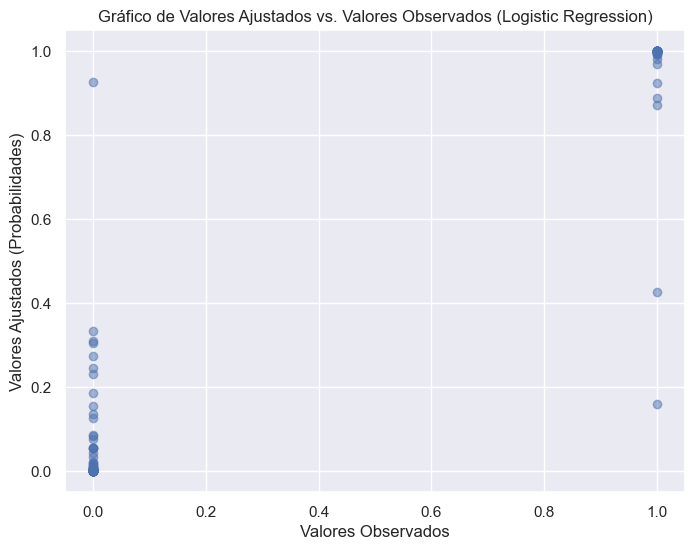

In [84]:
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred_lr)
confusion_lr_sin_pca = confusion_matrix(Y_test, y_pred_lr, normalize='true')
report = classification_report(Y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, model_lr.predict_proba(X_test)[:, 1], alpha=0.5, cmap=custom_cmap2)
plt.xlabel("Valores Observados")
plt.ylabel("Valores Ajustados (Probabilidades)")
plt.title("Gráfico de Valores Ajustados vs. Valores Observados (Logistic Regression)")
plt.savefig("ajustados_observados_lr.png", transparent=True)
plt.show()


- **Comparación de ambas curvas ROC y AUC**

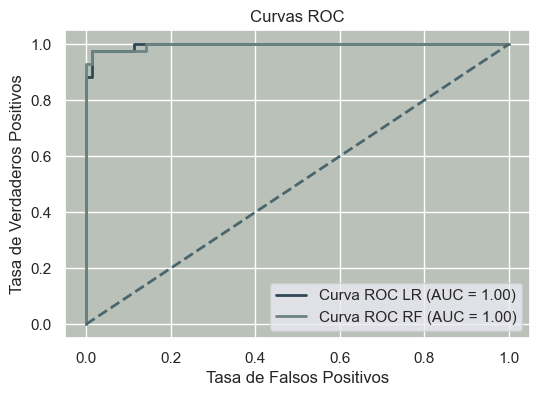

In [85]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y_test, y_pred_prob_lr_sin_pca)
roc_auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_prob_boot_sin_pca)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fpr_lr, tpr_lr, color='#2F4858', lw=2, label=f'Curva ROC LR (AUC = {roc_auc_lr:.2f})')

ax.plot(fpr_rf, tpr_rf, color='#6C8483', lw=2, label=f'Curva ROC RF (AUC = {roc_auc_rf:.2f})')

# Línea de referencia
ax.plot([0, 1], [0, 1], color='#4A666D', lw=2, linestyle='--')

# Etiquetas y título
ax.set_xlabel('Tasa de Falsos Positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos')
ax.set_title('Curvas ROC')
ax.legend(loc='lower right')
ax.set_facecolor('#BAC1B9')

# Muestra el subplot con ambas curvas ROC
plt.savefig("rocs.png", transparent=True)
plt.show()



- **Comparación de la curva de aprendizaje**

[0. 0. 0. 0.]


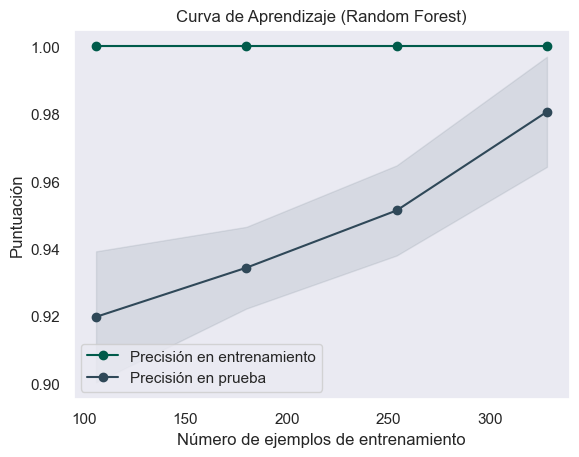

In [97]:
# Regresión Logística
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    train_sizes = train_sizes[1:]
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Número de ejemplos de entrenamiento")
    plt.ylabel("Puntuación")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(train_scores_std)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#7F9586")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2F4858")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#005B4B",
             label="Precisión en entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2F4858",
             label="Precisión en prueba")

    plt.legend(loc="best")

    return plt

plot_learning_curve(rf_boot, "Curva de Aprendizaje (Random Forest)", X_train, Y_train, cv=5)
plt.savefig("learning_curve_logistic.png", transparent=True)
plt.show()

# Random Forest


[0.00754717 0.00222222 0.00472441 0.00333977]


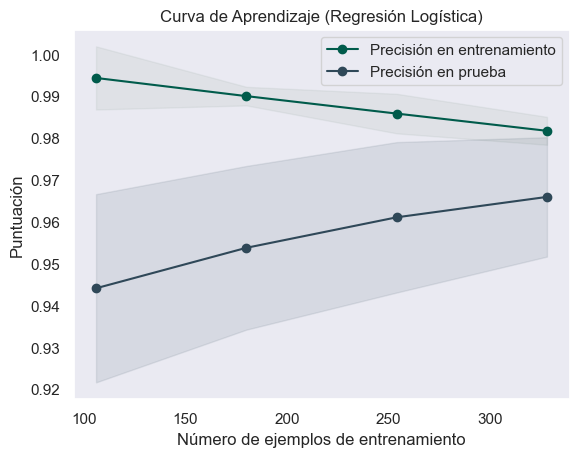

In [98]:
plot_learning_curve(model_lr, "Curva de Aprendizaje (Regresión Logística)", X_train, Y_train, cv=5)
plt.savefig("learning_curve_randomforest.png", transparent=True)
# Muestra la curva de aprendizaje
plt.show()

### 4.3 Conclusion Final

##**5.Técnicas utilizadas**


```
- Técnicas de preprocesado:
      Tratamiento de duplicados
      Eliminación de Outliers
      Tratamiento de datos faltantes
      Técnicas de sobremuestreo
      Transformación de variables dummies

- Técnicas de reducción dedimensionalidad:
      PCA
      Variables significativas
      Clustering

- Modelado con Regresión Logistica
- Modelado con KNN
- Modelado con diversos árboles de decisión
- Técnica de Validación Cruzada
- Técnica de Bootstrap
- Comparación de métodos con y sin utilizar componentes principales
- Evaluación de cada método con métricas de precisión, robusted, etc.
- Empleo de la Matriz de Confusión

```

